# Analysis on user timelines
To see how these user-timelines were downloaded, see:

`sm_w2v.__main__.run_user_timeline_download()`

Data were downloaded to:

`data/user_timeline_tweets.json`

In [1]:
# load and concatenate tweet timeline-documents
import json

train = False

user_timelines = dict()
with open('../data/user_timeline_tweets.json') as f_in:
    for l in f_in:
        try:
            twt = json.loads(l)
        except:
            continue
        user_id_str = twt['user']['id_str']
        if user_id_str in user_timelines:
            user_timelines[user_id_str] = user_timelines[user_id_str] + ' ' + twt['text']
        else:
            user_timelines[user_id_str] = twt['text']

# clean/preprocess text

In [2]:
from gensim.parsing.preprocessing import STOPWORDS
import re


STOPWORDS_ = ['rt', '', 'httpst', 'amp', 'https\'']

def clean_text(text):
    clean = re.sub(r'http.*$', '', text)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)

    clean = clean.lower()
    word_list = clean.split()
    word_list = [w for w in word_list if (w not in STOPWORDS_ and w not in STOPWORDS)]

    return word_list

user_clean_timelines = dict()
for user_id_str in user_timelines.keys():
    user_clean_timelines[user_id_str] = clean_text(user_timelines[user_id_str])

# LDA topic modeling on timeline documents

In [3]:
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim import corpora


user_timelines_keys = []
texts = []
for k, v in user_clean_timelines.items():
    user_timelines_keys.append(k)
    texts.append(v)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]
corpus = corpus[0:500]
print('number of user-timelines:', len(corpus))

if train:
    model = LdaModel(corpus, id2word=dictionary, num_topics=10, iterations=50, passes=10)
    model.save('../models/lda_user_timelines.model')

else:
    model = LdaModel.load('../models/lda_user_timelines.model')

number of user-timelines: 500


In [4]:
corpus

In [5]:
# idenitify topics of interest
model.print_topics(20)

[(0,
  '0.001*lyme + 0.001*hiring + 0.001*michaelsos + 0.000*nhl + 0.000*iheartawards + 0.000*adventure + 0.000*tim + 0.000*sos + 0.000*bestfanarmy + 0.000*ajax'),
 (1,
  '0.001*aday + 0.001*asmsg + 0.000*ik + 0.000*roundteam + 0.000*kwa + 0.000*jobsearch + 0.000*prolife + 0.000*breakingbad + 0.000*ntv + 0.000*marchmadness'),
 (2,
  '0.001*anc + 0.000*zuma + 0.000*ucsf + 0.000*nkandla + 0.000*ems + 0.000*feesmustfall + 0.000*malware + 0.000*rousseff + 0.000*fantasy + 0.000*worldaidsday'),
 (3,
  '0.000*abortion + 0.000*stubborn + 0.000*mgwv + 0.000*contracted + 0.000*raf + 0.000*samuel + 0.000*disclosure + 0.000*php + 0.000*traveler + 0.000*participation'),
 (4,
  '0.001*newsbreakslive + 0.001*drudgereport + 0.001*fuck + 0.001*prep + 0.001*realdonaldtrump + 0.000*lmao + 0.000*eau + 0.000*eu + 0.000*syria + 0.000*nigga'),
 (5,
  '0.001*gtav + 0.001*cannabis + 0.000*archives + 0.000*gta + 0.000*br + 0.000*physics + 0.000*fortitude + 0.000*franais + 0.000*charliesheen + 0.000*getfit'),
 (

In [6]:
# show users vs. features (topics)
features = dict()

for i, doc in enumerate(corpus):
    features[user_timelines_keys[i]] = model.get_document_topics(doc, minimum_probability=None)


In [7]:
# do time-plot of features for a specific user (topics) vs. time
import pandas as pd
import numpy as np

columns = ['topic0', 'topic1', 'topic2', 'topic3', 'topic4',
           'topic5', 'topic6', 'topic7', 'topic8', 'topic9']
index = user_timelines_keys
df = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns=columns, index=index)

for doc_ind, user_doc in enumerate(features.values()):
    for topic in user_doc:
        df.iloc[doc_ind, topic[0]] = topic[1]

In [8]:
df.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
1674188378,0.013527,0.013530,0.328451,0.013525,0.563215,0.013525,0.013647,0.013525,0.013525,0.013529
1670747473,0.013361,0.013361,0.013361,0.013361,0.414924,0.013361,0.013370,0.013372,0.013361,0.478168
4503233254,0.019280,0.019280,0.019280,0.019280,0.826479,0.019280,0.019282,0.019280,0.019280,0.019280
4396633306,0.043075,0.043075,0.043075,0.043075,0.043081,0.043075,0.612319,0.043075,0.043075,0.043075
2871169902,0.023094,0.023097,0.023094,0.023094,0.112453,0.023094,0.702777,0.023106,0.023094,0.023095


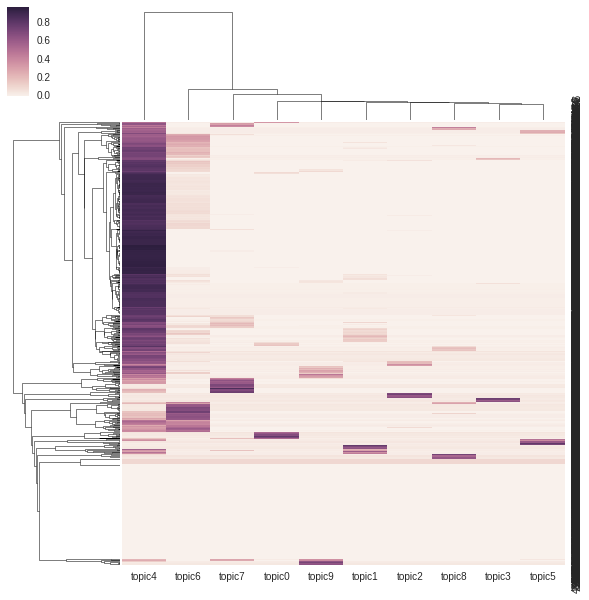

In [9]:
import seaborn as sns
%matplotlib inline

sns.clustermap(df)